In [1]:
# Core python libraries
import csv
import re
import math
import os
import time

# External libraries.
import nltk
import numpy
import pandas
import scipy
import sklearn
import tempfile
import pickle

# Tensorflow and related.
import tensorflow as tf

# Plotting
import matplotlib.pyplot as plt

# For dynamically reolading modules. imp.reload(module_name) 
import imp

# Internal libraries
import tf_utils

# So you know when this code block finishes.
print ("Done")

Done


In [2]:
#TODO(Max): make a library that does all this preprocessing
data = pandas.read_csv("data/train.csv") # Can read a subset. First nrows of the total.
LABEL_COLUMN = "SalaryNormalized"

TEST_SIZE = .2

print(len(data))

195971


In [3]:
# sklearn.cross_validation has been replaced with model_selection.
X_train_index, X_test_index, Y_train, Y_test = sklearn.model_selection.train_test_split(
    data.index, data[LABEL_COLUMN], test_size=TEST_SIZE, random_state=42)

# Keep train and test as pandas dataframes.
X_train = data.iloc[X_train_index]
X_test = data.iloc[X_test_index]

y_train = numpy.array(X_train[LABEL_COLUMN].astype(numpy.float32))
y_test = numpy.array(X_test[LABEL_COLUMN].astype(numpy.float32))

print ("Done")

Done


In [4]:
# Normalizing input values to mean 0, standard deviation 1.
train_mean, train_std = y_train.mean(), y_train.std()

# Normalize input labels and expectations
y_train = tf_utils.normalize_input(y_train, train_mean, train_std)
y_test = tf_utils.normalize_input(y_test, train_mean, train_std)


In [5]:
#imp.reload(tf_utils) 
def generate_kaggle_data():
    min_word_frequency = 30

    tfidf_vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(
        min_df=min_word_frequency, decode_error='ignore', tokenizer=tf_utils.PorterTokenizer())

    count_vectorizer = sklearn.feature_extraction.text.CountVectorizer(
        min_df=min_word_frequency, decode_error='ignore')

    # Transform BOW test set.
    # Transform title, full description, raw location

    def process_text_column(train_dataframe, test_dataframe, colname, vectorizer):
        print("Starting to process \"%s\" text column." % colname)
        train_output = vectorizer.fit_transform(train_dataframe[colname])
        test_output = vectorizer.transform(test_dataframe[colname])
        print("\"%s\" number of columns = %d" % (colname, train_output.shape[1]))
        return (train_output, test_output)

    #Count vectorizer this one, no stemming.
    location_raw_train, location_raw_test = process_text_column(X_train, X_test, "LocationRaw", count_vectorizer)

    # Text columns:
    title_train, title_test = process_text_column(X_train, X_test, "Title", tfidf_vectorizer)

    # This one takes a while: Pickle this bugger.
    print("Processing the \"FullDescription\" field will take a while")
    full_description_train, full_description_test = process_text_column(
        X_train, X_test, "FullDescription", tfidf_vectorizer)


    # Categorical columns: (category, contract, and source, were represented using a 1-of-K encoding.)
    # TODO(Max): Fix this the SKLEARN way
    """
    def process_categorical_column(train_dataframe, test_dataframe, colname, label_encoder, one_hot_encoder):
        print("Starting to process \"%s\" categorical column." % colname)
        train_output_labels = label_encoder.fit_transform(train_dataframe[colname].values.reshape(-1, 1))
        train_output_values = one_hot_encoder.fit_transform(train_output_labels)

        test_output_labels = label_encoder.transform(test_dataframe[colname].values.reshape(-1, 1))
        test_output_values = one_hot_encoder.transform(test_output_labels)

        print("\"%s\" number of columns = %d" % (colname, train_output_values.shape[1]))
        return (train_output_values, test_output_values)

    def process_categorical_column_dict(train_dataframe, test_dataframe, colname, dict_vectorizer):
        print("Starting to process \"%s\" categorical column." % colname)
        train_data = train_dataframe[colname].values()
        train_output_values = dict_vectorizer.fit_transform(train_data.to_dict())

        test_output_values = dict_vectorizer.transform(test_dataframe[colname].to_dict())
        #print(train_data)

        print(train_output_values)
        print("\"%s\" number of columns = %d" % (colname, train_output_values.shape[0]))
        return (train_output_values, test_output_values)
    """


    # label_encoder = sklearn.preprocessing.LabelEncoder()
    # one_hot_encoder = sklearn.preprocessing.OneHotEncoder()
    # dict_vectorizer = sklearn.feature_extraction.DictVectorizer()

    #category_train, category_test = process_categorical_column_dict(X_train, X_test, "Category", dict_vectorizer)
    # Hmmm... Company appears to add 6k columns
    cols_to_transform = ['Company', 'Category', 'ContractType', 'ContractTime', 'SourceName']
    sparse_df = pandas.get_dummies(data=data[cols_to_transform], columns = cols_to_transform , prefix=cols_to_transform, sparse=True)
    sparse_df_train = sparse_df.iloc[X_train_index]
    sparse_df_test = sparse_df.iloc[X_test_index]

    categorical_columns_sparse_matrix_train = scipy.sparse.csr_matrix(sparse_df_train)
    categorical_columns_sparse_matrix_test = scipy.sparse.csr_matrix(sparse_df_test)

    #print(sparse_df_train.columns.values)
    print(categorical_columns_sparse_matrix_train.shape)
    print(categorical_columns_sparse_matrix_test.shape)
    """
    category_train, category_test = process_categorical_column(X_train, X_test, "Category", label_encoder, one_hot_encoder)
    contract_type_train, contract_type_test = process_categorical_column(X_train, X_test, "ContractType", label_encoder, one_hot_encoder)
    contract_time_train, contract_time_test = process_categorical_column(X_train, X_test, "ContractTime", label_encoder, one_hot_encoder)
    source_train, source_test = process_categorical_column(X_train, X_test, "SourceName", label_encoder, one_hot_encoder)
    """
    # Why not company?


    # Stack all the sparse datasets.

    # Unsure if I need this one.
    normalizer = sklearn.preprocessing.Normalizer()

    x_train = normalizer.fit_transform(scipy.sparse.csr_matrix(scipy.sparse.hstack(
        [title_train, location_raw_train, full_description_train, categorical_columns_sparse_matrix_train])
                                      ))
    x_test = normalizer.transform(scipy.sparse.csr_matrix(scipy.sparse.hstack(
        [title_test, location_raw_test, full_description_test, categorical_columns_sparse_matrix_test])
    ))
    print("x_train shape: %s, %s" % x_train.shape)
    print("x_test shape: %s, %s" % x_test.shape)

    # Need this for my batch code below
    assert type(x_train) == scipy.sparse.csr_matrix
    assert type(x_test)== scipy.sparse.csr_matrix
    return x_train, x_test

In [6]:
kaggle_file = "kaggle_output.pkl" 

if os.path.isfile(kaggle_file):
    kaggle_dict = pickle.load( open(kaggle_file, "rb" ) )
    x_train, x_test = kaggle_dict["x_train"],  kaggle_dict["x_test"]
else:
    x_train, x_test = generate_kaggle_data()
    pickle.dump({'x_train': x_train, 'x_test':x_test}, open(kaggle_file, 'wb'))


In [7]:
# Define data nput functions. These have to be done here as the 
# functions take no arguments. Also the dict labels are specific to 
# the model.
#TODO(buckleym): Remove
DIMENSIONS = x_train.shape[1]

def input_fn():
    for batch_input, batch_labels in tf_utils.generate_batch(
        batch_size, number_of_batches, DIMENSIONS, x_train, y_train):
        yield {input_data: batch_input, input_target: batch_labels, keep_prob: DROPOUT_KEEP_PROBABILITY}

def eval_input_fn():
    for batch_input, batch_labels in tf_utils.generate_batch(
        batch_size, number_of_validation_batches, DIMENSIONS, x_test, y_test):
        yield {input_data: batch_input, input_target: batch_labels, keep_prob: 1.0}


In [8]:
# Define model
#del third_layer_output
# del tf.name_scope("third_hidden_layer")
graph = tf.Graph()

sess = tf.Session(graph=graph)

learning_rate = .01

l1_regularization_coef = 0.0 #1
l2_regularization_coef = 0.0 #1

# Implement this by batch.
batch_size = 512

#(128,64,16) worked very well
# (1024, 256, 64) Doesn't work
# (128, 32, 8) Neither
FIRST_LAYER_SIZE = 2056
SECOND_LAYER_SIZE = 512
THIRD_LAYER_SIZE = 128
FOURTH_LAYER_SIZE = 64
FIFTH_LAYER_SIZE = 16

# Given small layers probably need this a little higher.
DROPOUT_KEEP_PROBABILITY = 1.0#5

with graph.as_default():

    with tf.name_scope("input_data"):
        # Initialize data placeholders
        input_data = tf.placeholder(shape=[batch_size, DIMENSIONS], dtype=tf.float32)
        input_target = tf.placeholder(shape=[batch_size, 1], dtype=tf.float32, name="labels")
        keep_prob = tf.placeholder(tf.float32)

    with tf.device('/gpu:0'):

        with tf.name_scope("first_hidden_layer"):
            first_layer_hidden_units = tf.Variable(tf.random_uniform(shape=[DIMENSIONS, FIRST_LAYER_SIZE], minval=-1, maxval=1))
            first_layer_bias = tf.Variable(tf.random_uniform(shape=[1], minval=-1, maxval=1))
            first_layer_product = tf.matmul(input_data, first_layer_hidden_units)
            first_layer_output = tf.contrib.layers.dropout(
                tf.nn.relu(tf.add(first_layer_product, first_layer_bias)), keep_prob)
            
        with tf.name_scope("second_hidden_layer"):
            second_layer_hidden_units = tf.Variable(tf.random_uniform(shape=[FIRST_LAYER_SIZE, SECOND_LAYER_SIZE], minval=-1, maxval=1))
            second_layer_bias = tf.Variable(tf.random_uniform(shape=[1], minval=-1, maxval=1))
            second_layer_product = tf.matmul(first_layer_output, second_layer_hidden_units)
            second_layer_output = tf.contrib.layers.dropout(
                tf.nn.relu(tf.add(second_layer_product, second_layer_bias)), keep_prob)
            
        with tf.name_scope("third_hidden_layer"):
            third_layer_hidden_units = tf.Variable(tf.random_uniform(shape=[SECOND_LAYER_SIZE, THIRD_LAYER_SIZE], minval=-1, maxval=1))
            third_layer_bias = tf.Variable(tf.random_uniform(shape=[1], minval=-1, maxval=1))
            third_layer_product = tf.matmul(second_layer_output, third_layer_hidden_units)
            third_layer_output = tf.contrib.layers.dropout(
                tf.nn.relu(tf.add(third_layer_product, third_layer_bias)), keep_prob)
        with tf.name_scope("fourth_hidden_layer"):
            fourth_layer_hidden_units = tf.Variable(tf.random_uniform(shape=[THIRD_LAYER_SIZE, FOURTH_LAYER_SIZE], minval=-1, maxval=1))
            fourth_layer_bias = tf.Variable(tf.random_uniform(shape=[1], minval=-1, maxval=1))
            fourth_layer_product = tf.matmul(third_layer_output, fourth_layer_hidden_units)
            fourth_layer_output = tf.contrib.layers.dropout(
                tf.nn.relu(tf.add(fourth_layer_product, fourth_layer_bias)), keep_prob)
            
        with tf.name_scope("fifth_hidden_layer"):
            fifth_layer_hidden_units = tf.Variable(tf.random_uniform(shape=[FOURTH_LAYER_SIZE, FIFTH_LAYER_SIZE], minval=-1, maxval=1))
            fifth_layer_bias = tf.Variable(tf.random_uniform(shape=[1], minval=-1, maxval=1))
            fifth_layer_product = tf.matmul(fourth_layer_output, fifth_layer_hidden_units)
            fifth_layer_output = tf.contrib.layers.dropout(
                tf.nn.relu(tf.add(fifth_layer_product, fifth_layer_bias)), keep_prob)
               
        with tf.name_scope("output_layer"):
            output_layer_coefficients = tf.Variable(tf.random_uniform(shape=[FIFTH_LAYER_SIZE, 1], minval=-1, maxval=1))
            output_layer_bias = tf.Variable(tf.random_uniform(shape=[1], minval=-1, maxval=1))
            output_layer_product = tf.matmul(fifth_layer_output, output_layer_coefficients)
            model_output = tf.add(output_layer_product, output_layer_bias, name="predictions")

    with tf.name_scope("loss"):
        # Mean Absolute Error.
        mae = tf.reduce_mean(tf.abs(tf.subtract(input_target, model_output)))
        
        loss = mae

        # If we are using regularization.
        if l1_regularization_coef > 0 or l2_regularization_coef > 0:
            l1_regularizer = tf.contrib.layers.l1_regularizer(scale=l1_regularization_coef)
            l2_regularizer = tf.contrib.layers.l2_regularizer(scale=l2_regularization_coef)

            weights = tf.trainable_variables() # all vars of your graph
            regularization_penalty = tf.add(tf.contrib.layers.apply_regularization(l1_regularizer, weights),
                                             tf.contrib.layers.apply_regularization(l2_regularizer, weights))
            loss = loss + regularization_penalty # this loss needs to be minimized

    with tf.name_scope("reporting"):
        # Converts back to original, salary scale.
        error_salary_scale = tf.reduce_mean(tf.abs(tf.multiply(mae, train_std)))

        # Log for tensorboard
        training_summary = tf.summary.scalar('train_loss', loss)
        validation_summary = tf.summary.scalar('validation_loss', loss)
        # Add mean absolute errors.
        training_mae = tf.summary.scalar('train_mae', error_salary_scale)
        validation_mae = tf.summary.scalar('validation_mae', error_salary_scale)

    global_step = tf.Variable(0, name='global_step', trainable=False)

    # Declare optimizer
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)

    # This one seems to work better :D
    train_op = tf.contrib.layers.optimize_loss(      
     loss, tf.contrib.framework.get_global_step(),      
     optimizer='Adam'
        , learning_rate=learning_rate)


In [10]:
# Number of
number_of_epochs = 10000000
batches_per_epoch = x_train.shape[0]/batch_size
number_of_batches = math.ceil(x_train.shape[0]/batch_size)
number_of_validation_batches = number_of_batches

logs_dir = "logs/neuralnetkaggleinspired1layer"

checkpoint_frequency = 250

reporting_frequency = 1

total_loss = 0
validation_loss = 0
validation_batch_average_window = 100

ckpt = None
ckpt = tf.train.get_checkpoint_state(logs_dir)  

In [ ]:
# Where to save this model.
model_path = os.path.join(logs_dir, time.strftime("%Y-%m-%d-%H-%M-%S"))

if ckpt:
    restore_from_model = True
    print("Restore from model!")
else:
    restore_from_model = False

with tf.Session(graph=graph, config=tf.ConfigProto(
    allow_soft_placement=True, log_device_placement=True)) as session:
    summaries = tf.summary.merge_all()                                                       
    writer = tf.summary.FileWriter(model_path,
        graph=session.graph)                  

    saver = tf.train.Saver(tf.global_variables()) 
                                                                                                  
    session.run(tf.global_variables_initializer())
    
    
    if restore_from_model:
        saver.restore(session, ckpt.model_checkpoint_path)
        
    global_step = 0
        
    for epoch in range(number_of_epochs):
        eval_feed_generator = eval_input_fn()
        # Shuffle the training input
        x_train, y_train = tf_utils.unison_shuffled_copies(x_train, y_train)

        for step, feed_dict in enumerate(input_fn()):
            global_step += 1
            start_time = time.time()

            _, temp_loss = session.run([train_op, loss], feed_dict=feed_dict)
            
            duration = time.time() - start_time
            
            if global_step % reporting_frequency == 0:
                print("Epoch: %s Iteration: %s : Loss: %.4f (%.3f sec)" % 
                      (epoch, (step + 1), temp_loss, duration))

                train_summ, train_mae = session.run([training_summary, training_mae], feed_dict=feed_dict)
                writer.add_summary(train_summ, global_step)
                writer.add_summary(train_mae, global_step)
                _, valid_summ, valid_mae = session.run(
                        [loss, validation_summary, validation_mae],
                        feed_dict=next(eval_feed_generator))
                writer.add_summary(valid_summ, global_step)
                writer.add_summary(valid_mae, global_step)

                writer.flush()                

            if (global_step % checkpoint_frequency == 0) or (global_step == number_of_batches):
                print("Saving at epoch %s step: %s" % (epoch, step + 1))
                saver.save(session, model_path, global_step=tf.contrib.framework.get_global_step())

Restore from model!
INFO:tensorflow:Restoring parameters from logs/neuralnetkaggleinspired1layer/2017-07-06-22-38-40-75750
Epoch: 0 Iteration: 1 : Loss: 0.0201 (0.462 sec)
Epoch: 0 Iteration: 2 : Loss: 0.0211 (0.183 sec)
Epoch: 0 Iteration: 3 : Loss: 0.0199 (0.177 sec)
Epoch: 0 Iteration: 4 : Loss: 0.0205 (0.178 sec)
Epoch: 0 Iteration: 5 : Loss: 0.0216 (0.172 sec)
Epoch: 0 Iteration: 6 : Loss: 0.0223 (0.173 sec)
Epoch: 0 Iteration: 7 : Loss: 0.0230 (0.179 sec)
Epoch: 0 Iteration: 8 : Loss: 0.0212 (0.177 sec)
Epoch: 0 Iteration: 9 : Loss: 0.0199 (0.176 sec)
Epoch: 0 Iteration: 10 : Loss: 0.0199 (0.179 sec)
Epoch: 0 Iteration: 11 : Loss: 0.0220 (0.206 sec)
Epoch: 0 Iteration: 12 : Loss: 0.0198 (0.207 sec)
Epoch: 0 Iteration: 13 : Loss: 0.0172 (0.177 sec)
Epoch: 0 Iteration: 14 : Loss: 0.0191 (0.187 sec)
Epoch: 0 Iteration: 15 : Loss: 0.0206 (0.193 sec)
Epoch: 0 Iteration: 16 : Loss: 0.0193 (0.181 sec)
Epoch: 0 Iteration: 17 : Loss: 0.0213 (0.178 sec)
Epoch: 0 Iteration: 18 : Loss: 0.021

In [10]:
# Model Evaluation
# number_of_validation_batches is used above in the eval_input_fn
number_of_validation_batches = math.floor(x_test.shape[0]/batch_size)
# Load checkpointed model.
ckpt = tf.train.get_checkpoint_state(logs_dir)                                     

# Write TF Model Evaluation Code here. 
with tf.Session(graph=graph, config=tf.ConfigProto(
    allow_soft_placement=True, log_device_placement=True)) as session:
    
    saver = tf.train.Saver(tf.global_variables()) 
                                                                                                  
    session.run(tf.global_variables_initializer())
    
    saver.restore(session, ckpt.model_checkpoint_path)
    prediction_array_list = []

    total_loss = 0
    for step, eval_feed_dict in enumerate(eval_input_fn()):    
        valid_loss, mae, model_predictions = session.run(
            [loss, error_salary_scale, model_output], feed_dict=eval_feed_dict)
        #print("Batch: %d Mean: %.4f" % (step, mae))
        total_loss += mae
        prediction_array_list.append(model_predictions)
    print ("Mean Absolute Error Loss over all %s observations = %s" % ((step + 1) * batch_size, total_loss / (step + 1)))

INFO:tensorflow:Restoring parameters from logs/neuralnetkaggleinspired1layer/2017-07-06-22-38-40-75750
Mean Absolute Error Loss over all 38912 observations = 5050.69442588


In [50]:
def flatten_predictions(predictions):
    return numpy.concatenate(predictions)

predictions = flatten_predictions(prediction_array_list)

n_predictions = predictions.shape[0]

actuals = y_test[0:n_predictions]

print(n_predictions, actuals.shape)
print(y_test)

51200 (51200,)
[ 0.89645004 -0.66550416  3.22435188 ..., -0.29010177  0.89645004
  0.95295256]


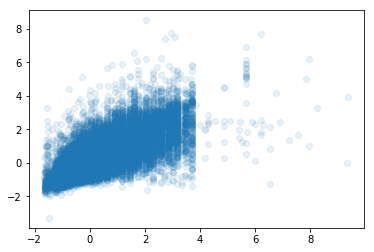

[[-1.2662046  -2.82815886  1.06169724 ...,  0.65487933 -2.19849539
  -2.53751016]
 [ 2.22026563  0.65831143  4.54816723 ...,  4.14134979  1.28797495
   0.94896007]
 [-4.18580246 -5.74775648 -1.85790062 ..., -2.26471853 -5.11809301
  -5.45710802]
 ..., 
 [-1.50738144 -3.0693357   0.8205204  ...,  0.41370249 -2.43967223
  -2.778687  ]
 [ 0.8513     -0.7106542   3.17920184 ...,  2.77238393 -0.0809907
  -0.42000553]
 [ 1.43651092 -0.12544328  3.76441288 ...,  3.35759497  0.50422019
   0.16520539]]


In [51]:
%matplotlib inline

def print_results(x_vals, y_vals):

    plt.scatter(x_vals, y_vals, alpha=.1)
    plt.show()

    print(x_vals-y_vals)
    #print(sorted([set(y_vals)]))

print_results(actuals, predictions)